In [1]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
import ltn
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper
from ltn_imp.fuzzy_operators.aggregators import SatAgg
from ltn_imp.parsing.parser import LTNConverter

## Data Preparation

In [2]:
!poetry run poe download-datasets

Poe => mkdir -p examples/datasets
Poe => curl -L -o examples/datasets/iris_training.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_training.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0  45535      0 --:--:-- --:--:-- --:--:-- 46208
Poe => curl -L -o examples/datasets/iris_test.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_test.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598  100   598    0     0  10191      0 --:--:-- --:--:-- --:--:-- 10310


In [3]:
train_data = pd.read_csv("datasets/iris_training.csv")
test_data = pd.read_csv("datasets/iris_test.csv")

train_labels = train_data.pop("species")
test_labels = test_data.pop("species")

train_data = torch.tensor(train_data.to_numpy()).float()
test_data = torch.tensor(test_data.to_numpy()).float()
train_labels = torch.tensor(train_labels.to_numpy()).long()
test_labels = torch.tensor(test_labels.to_numpy()).long()

In [4]:
pd.DataFrame(train_labels).value_counts()

0
0    42
2    42
1    36
Name: count, dtype: int64

In [5]:
# we define predicate P
class MLP(torch.nn.Module):
    """
    This model returns the logits for the classes given an input example. It does not compute the softmax, so the output
    are not normalized.
    This is done to separate the accuracy computation from the satisfaction level computation. Go through the example
    to understand it.
    """
    def __init__(self, layer_sizes=(4, 16, 16, 8, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        """
        Method which defines the forward phase of the neural network for our multi class classification task.
        In particular, it returns the logits for the classes given an input example.

        :param x: the features of the example
        :param training: whether the network is in training mode (dropout applied) or validation mode (dropout not applied)
        :return: logits for example x
        """
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=True):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out

In [6]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]

            yield data, labels

# create train and test loader
train_loader = DataLoader(train_data, train_labels, 64, shuffle=True)
test_loader = DataLoader(test_data, test_labels, 64, shuffle=False)

In [7]:
def compute_accuracy(loader, model, num_classes):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for data, labels in loader:
        predictions = model(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        labels = labels.numpy()  # Convert labels to numpy array

        for i in range(num_classes):
            class_mask = (labels == i)
            class_correct[i] += np.sum(predictions[class_mask] == labels[class_mask])
            class_total[i] += np.sum(class_mask)

    class_accuracy = class_correct / class_total

    # Print accuracy for each class
    for i in range(num_classes):
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')

    # Compute and print general accuracy
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f'Overall accuracy: {overall_accuracy:.2f}')

## My Implementation

In [8]:
mlp = MLP()
model = LogitsToPredicate(mlp)

In [9]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 0.79
Accuracy for class 1: 1.00
Accuracy for class 2: 0.00
Overall accuracy: 0.57


In [10]:
compute_accuracy(test_loader, model = mlp,num_classes=3)

Accuracy for class 0: 0.75
Accuracy for class 1: 1.00
Accuracy for class 2: 0.00
Overall accuracy: 0.67


In [11]:
# Define the rules
expression_1 = "all x. ((y = zero) -> Classifier(x, zero))"
expression_2 = "all x. ((y = one) -> Classifier(x, one))"
expression_3 = "all x. ((y = two) -> Classifier(x, two))"

rules = [expression_1, expression_2, expression_3]

# Initialize the satisfaction aggregator and optimizer
sat_agg = SatAgg()
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.001)
converter = LTNConverter(predicates={"Classifier": model}, quantifier_impls={"forall": "pmean_error"})

# Convert the rules
rules = [converter(rule, process=False) for rule in rules]

log_steps = 100
# Training loop
for epoch in range(801):

    for batch in train_loader:

        results = []

        data, label = batch
        
        # Convert labels to one-hot encoding
        label = torch.stack([torch.tensor([1., 0., 0.]) if l == 0 else torch.tensor([0., 1., 0.]) if l == 1 else torch.tensor([0., 0., 1.]) for l in label])

        # Create variable mapping for the entire batch
        var_mapping = {"x": data, "y": label, "zero": torch.tensor([1., 0., 0.]),"one": torch.tensor([0., 1., 0.]), "two": torch.tensor([0., 0., 1.])}

        # Apply rules to the entire batch
        for rule in rules:
            results.append(rule(var_mapping))

    # Calculate the loss
    loss = 1- sat_agg(*results)

    # Ensure loss is a tensor and connected to the computation graph
    assert isinstance(loss, torch.Tensor), "Loss is not a tensor"
    assert loss.grad_fn is not None, "Loss has no grad_fn, indicating it is not connected to the computation graph"

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % log_steps == 0:
        print([str(rule) for rule in rules])
        print("Results:", results)
        print("Loss:", loss)
        print()

['all x.((y = zero) -> Classifier(x,zero))', 'all x.((y = one) -> Classifier(x,one))', 'all x.((y = two) -> Classifier(x,two))']
Results: [tensor(0.6126, grad_fn=<RsubBackward1>), tensor(0.6614, grad_fn=<RsubBackward1>), tensor(0.5833, grad_fn=<RsubBackward1>)]
Loss: tensor(0.3823, grad_fn=<RsubBackward1>)

['all x.((y = zero) -> Classifier(x,zero))', 'all x.((y = one) -> Classifier(x,one))', 'all x.((y = two) -> Classifier(x,two))']
Results: [tensor(0.9189, grad_fn=<RsubBackward1>), tensor(0.6298, grad_fn=<RsubBackward1>), tensor(0.7868, grad_fn=<RsubBackward1>)]
Loss: tensor(0.2510, grad_fn=<RsubBackward1>)

['all x.((y = zero) -> Classifier(x,zero))', 'all x.((y = one) -> Classifier(x,one))', 'all x.((y = two) -> Classifier(x,two))']
Results: [tensor(0.9389, grad_fn=<RsubBackward1>), tensor(0.7474, grad_fn=<RsubBackward1>), tensor(0.8302, grad_fn=<RsubBackward1>)]
Loss: tensor(0.1792, grad_fn=<RsubBackward1>)

['all x.((y = zero) -> Classifier(x,zero))', 'all x.((y = one) -> Classif

In [12]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.94
Accuracy for class 2: 1.00
Overall accuracy: 0.98


In [13]:
compute_accuracy(test_loader,model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.93
Accuracy for class 2: 1.00
Overall accuracy: 0.97


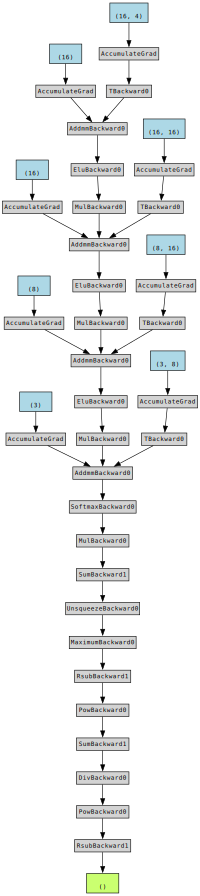

In [14]:
data, label = next(iter(test_loader))

# Convert labels to one-hot encoding
label = torch.stack([torch.tensor([1., 0., 0.]) if l == 0 else torch.tensor([0., 1., 0.]) if l == 1 else torch.tensor([0., 0., 1.]) for l in label])

# Create variable mapping for the entire batch
var_mapping = {"x": data, "y": label, "zero": torch.tensor([1., 0., 0.]),"one": torch.tensor([0., 1., 0.]), "two": torch.tensor([0., 0., 1.])}

rules[0].comp_graph(var_mapping)